# Problem description

   In cytogenetics, experiments typically starts from chromosomal preparations fixed on glass slides. Occasionally a chromosome can fall on another one, yielding overlapping chromosomes in the image. Before computers and images processing with photography, chromosomes were cut from a paper picture and then classified (at least two paper pictures were required when chromosomes are overlapping). Automatic segmentation methods were developped to overcome this problem, however, these methods rely on a geometric analysis of the chromosome contour and require some human intervention when partial overlap occurs.
   
   The [QFISH on metaphase](https://en.wikipedia.org/wiki/Q-FISH) was classified as a [low-throughput method for quantitative analysis of the lenght of the telomeres](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3409675/figure/F1/) by Vera and Blasco. One of the botleneck of the method is the resolution of the the overlapping chromosomes. 
Modern deep-learning techniques have the potential to provide a more reliable, fully-automated solution.


### Cytogenetics references
  * [A Geometric Approach To Fully Automatic Chromosome Segmentation](https://arxiv.org/abs/1112.4164)
  * [Automated Discrimination of Dicentric and Monocentric Chromosomes by Machine Learning-based Image Processing](http://biorxiv.org/content/biorxiv/early/2016/01/19/037309.full.pdf)
  * [An Efficient Segmentation Method for Overlapping Chromosome Images](http://research.ijcaonline.org/volume95/number1/pxc3894861.pdf)
  * [A Review of Cytogenetics and its Automation](http://www.scialert.net/qredirect.php?doi=jms.2007.1.18&linkid=pdf)

## Libraries required to run this notebook:

This notebook is run from [jupyter](http://jupyter.org/) with a python2 Kernel on a [Ubuntu 16.04 OS](https://www.ubuntu.com/desktop) inside a virtual environnement using the python packages available on the system. Several image processing libraries are used:

   * [mahotas](http://luispedro.org/software/mahotas/)
   * [opencv](http://opencv.org/)
   * [scipy](https://www.scipy.org/)
   * [Numpy](http://www.numpy.org/)
   * [scikit-image](http://scikit-image.org/)
    
### Aim of the notebook

The aim of this notbook is to produce a dataset large enough to train a supervised learning algorithm (semantic segmentation) capable of segmenting overlapping chromosomes. The overlapping chromosomes generated, imply only two chromosomes (this is a start). They are obtained by varying the relative positions and orientations of the two chromosomes.

The considered algorithms could be segnet. Different  implementations are available in the current deep-learning frameworks:
     
* [theano+keras+python](https://github.com/pradyu1993/segnet/blob/master/segnet.py)
* [caffe + python](https://github.com/alexgkendall/caffe-segnet)
* [torch](https://github.com/yandex/segnet-torch)

The latter deep-learning framework is supposed to be more efficient than the segnet implementation:

* [Enet + torch + lua](https://github.com/e-lab/ENet-training).

# Import libraries

In [1]:
import sys
import cv2
print cv2.__version__

3.1.0


In [2]:
import mahotas as mh
import scipy

In [3]:
import itertools

from scipy import ndimage as nd
import numpy as np
import skimage as sk
#print sk.__version__
from skimage import io
from skimage import filters
from skimage import segmentation as skg
from generator_tools import ResizeImages
                        
from generator_tools import overlapping_generator, ResizeImages
from segmentation import extractParticles_2

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


0.12.3


In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [5]:
import h5py

In [6]:
%matplotlib inline

## Generate overlappings chromosomes from images of lymphocytes chromosomes:
* Choose a metaphase with no nuclei in the field
* Lucky! Found a metaphase with no overlapping chromosomes
* Segment the chromosomes
* Make pairs of single chromosomes
* Generate overlappings of pair of chromosomes with the corresponding [ground-truth](https://en.wikipedia.org/wiki/Ground_truth) label of the DAPI component.

In [7]:
metaphase ='3'

path_dapi = '../Raw images/jpp21/' + metaphase + '/dapi/1.tif'
path_cy3 =  '../Raw images/jpp21/' + metaphase + '/cy3/1.tif'

dapi = mh.imread(path_dapi)[50:900,300:1150]
cy3 = mh.imread(path_cy3)[50:900:,300:1150]

#### For images segmentation, it's easier to work on 8bits images. Convert first the raw images from 12 to 8 bits.

In [8]:
d8 = np.uint8(dapi/16.0)
cy8 = np.uint8(cy3/16.0)
print d8.dtype

uint8


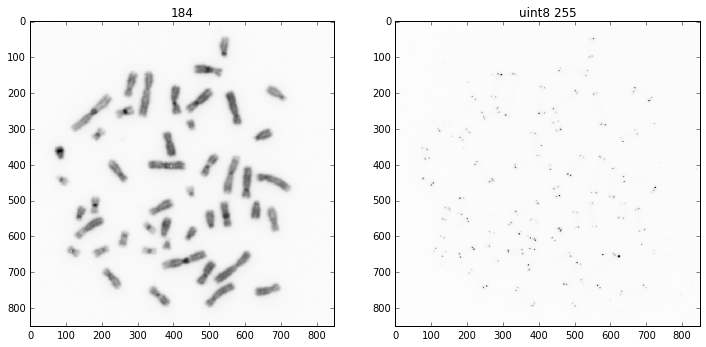

In [9]:
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.title(str(d8.max()))
plt.imshow(d8,interpolation='nearest',cmap=plt.cm.Greys)

plt.subplot(122)
plt.title(str(cy8.dtype)+' '+str(cy8.max()))
plt.imshow(cy8,interpolation='nearest',cmap=plt.cm.Greys)

### Then let's perform background substraction using top-hat filtering with a large structuring element

In [10]:
kernel100 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
kernel18 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

Top-Hat filtering with a large structuring element with opencv is just fast

In [11]:
dapi_cv = cv2.morphologyEx(d8, cv2.MORPH_TOPHAT, kernel100)
cy3_cv = cv2.morphologyEx(cy8, cv2.MORPH_TOPHAT, kernel18)

In [12]:
dapi_cv = 1.0*dapi_cv - 5
dapi_cv[dapi_cv <0] = 0
dapi_cv = np.uint8(dapi_cv)

cy3_cv = 1.0*cy3_cv - 5
cy3_cv[cy3_cv<0] = 0
cy3_cv = np.uint8(cy3_cv)

A color image can be generated

In [13]:
red = np.uint8(cy3_cv)
green = np.zeros(cy3_cv.shape, dtype=np.uint8)
blue = np.uint8(dapi_cv)

color = np.dstack((red, green, blue))

### Make low resolution images, why?


Making a large dataset generates a large RAM imprint (although there is a solution to process images with disk, overcomming the limitations due to the RAM) limiting the possibility to vary :
   * the chromosomes used to generate overlapping
   * the positions of the chromosomes

Deep-learning algorithms require a lot of examples.Processing them is not costless, by reducing the size of the images, the training time may be kept reasonably short, on a laptop with a modest nvidia gpu.

In [14]:
dap_lr = dapi_cv[::4,::4]
cy3_lr = cy3_cv[::4,::4]

### Perform chromosomes segmentation:
   * This is required to extract chromosomes.
   * Segmentation can be done on a combination of the DAPI image and the Cy3 image

In [15]:
combin = (1.0*dap_lr + 1.0*cy3_lr)/2

comb2 = sk.exposure.rescale_intensity(combin)
comb2 = np.uint8(255*comb2)

seg = filters.threshold_adaptive(comb2, block_size = 51)
seg = sk.morphology.binary_opening(seg, selem = sk.morphology.disk(1))
#seg2 = sk.morphology.binary_closing(seg2, selem = sk.morphology.disk(1))
seg = sk.segmentation.clear_border(seg, buffer_size=3)

label, _ = mh.labeled.label(seg)
#print labskel.dtype
size = mh.labeled.labeled_size(label)
#print size_sk
chroms = mh.labeled.remove_regions_where(label, size < 20)
mh.labeled.relabel(chroms, inplace= True)
#lab_dil = sk.morphology.dilation(chroms)
#print chroms.dtype,lab_dil.dtype

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 46L)

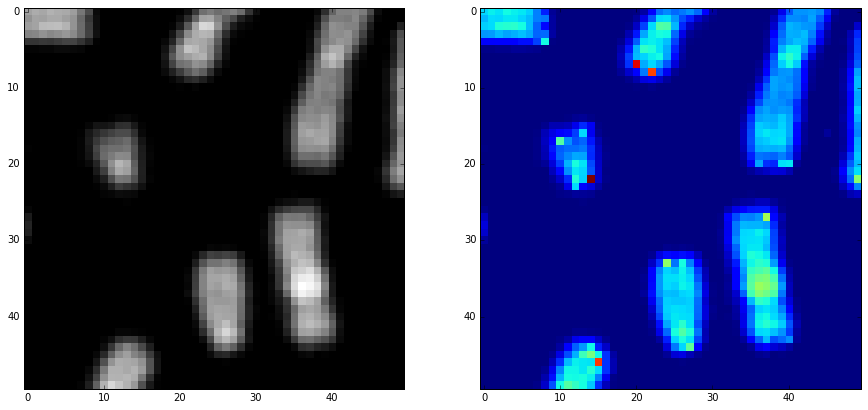

In [16]:
plt.figure(figsize=(15, 20))
plt.subplot(121)
plt.imshow(dap_lr[100:150,100:150], cmap=plt.cm.gray,interpolation ='nearest')
plt.subplot(122)
plt.imshow(comb2[100:150,100:150], interpolation ='nearest')

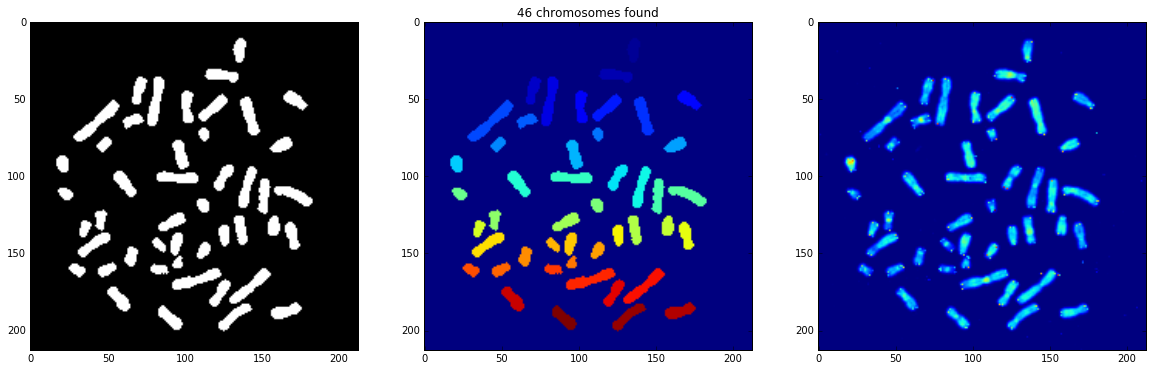

In [17]:
plt.figure(figsize=(20, 15))
plt.subplot(131)
plt.imshow(seg, cmap=plt.cm.gray)
plt.subplot(132)
plt.title(str(chroms.max())+' chromosomes found')
plt.imshow(chroms)
plt.subplot(133)
plt.imshow(comb2)

## The chromosomes can now be extracted individually

In [18]:
candidates = extractParticles_2(comb2, chroms)
chromosomes_rgb = extractParticles_2(color, chroms)

In [19]:
gallery = ResizeImages(candidates)
single_chroms_rgb = ResizeImages(chromosomes_rgb)

In [20]:
#print type(gallery)
chroms_stack = sk.io.concatenate_images(gallery)
#chroms_stack = np.asarray(chroms_stack, dtype=np.int8)
print chroms_stack.shape
print chroms_stack.dtype

(46, 32, 32)
uint8


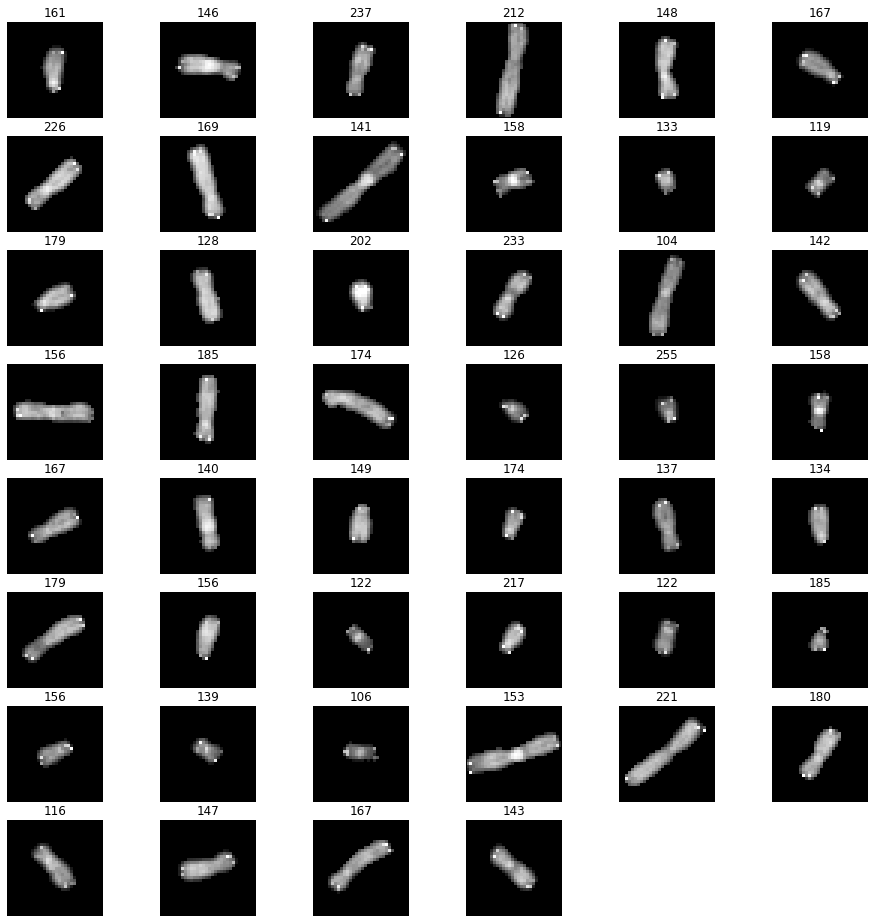

In [21]:
plt.figure(figsize=(16, 16))
for i, image in enumerate(gallery):#in range(46):#
    plt.subplot(8,6,i+1, xticks=[],yticks=[])
    #image = chroms_stack[i,:,:]
    plt.imshow(image, interpolation='nearest', cmap = plt.cm.Greys_r, vmin=0,vmax=150)
    plt.title(str(image.max()))

## Make all the possible pairs of chromosomes

In [22]:
all_pairs = []
for pair in itertools.combinations(gallery, 2):
    area1 = np.sum(pair[0]>0)
    area2 = np.sum(pair[1]>0)
    all_pairs.append(((area1, area2), pair))

### Display a pair of chromosomes

<type 'numpy.ndarray'>


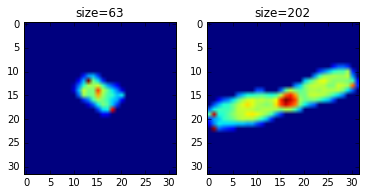

In [23]:
pairs_index = 1000
im1 = all_pairs[pairs_index][1][0]
im2 = all_pairs[pairs_index][1][1]
size1 = all_pairs[pairs_index][0][0]
size2 = all_pairs[pairs_index][0][1]

print type(im1[0])
plt.subplot(121)
plt.title('size='+str(size1))
plt.imshow(im1)
plt.subplot(122)
plt.title('size='+str(size2))
plt.imshow(im2)

## Generate overlapping for each/some pairs:
Each chromosome is rotated by an angle value, for eg **15°** yielding 24x24=576 pairs of images then for each pair one chromosome is translated horizontally and vertically yielding more examples of possible chromosome overlapps. Finally, non overlapping chromosomes are discarded.
The more rotation angle is small and the more le translation number is large, the more the number of overlapping chromosomes is large et potentially overcome the RAM capacity.

There are 1035 pairs of chromosomes, combined with 24x24 rotations, combined with ~10x10 translations, yielding potentially 60 000 000 examples of overlapping chromosomes. Thus only a subset of pairs can be chosen, possibly representing all kind of chromosomal morphologies or sizes.

In [24]:
print 'Number of pairs of chromosomes:',len(all_pairs)
print 'Number of pairs of chromosomes:',len(all_pairs[::37])

Number of pairs of chromosomes: 1035
Number of pairs of chromosomes: 28


## Let's keep a subset of chromosomes pairs:
And have a rough look to them, checking their sizes. There are pairs between big/small chromosomes, big/big, medium/small etc ...

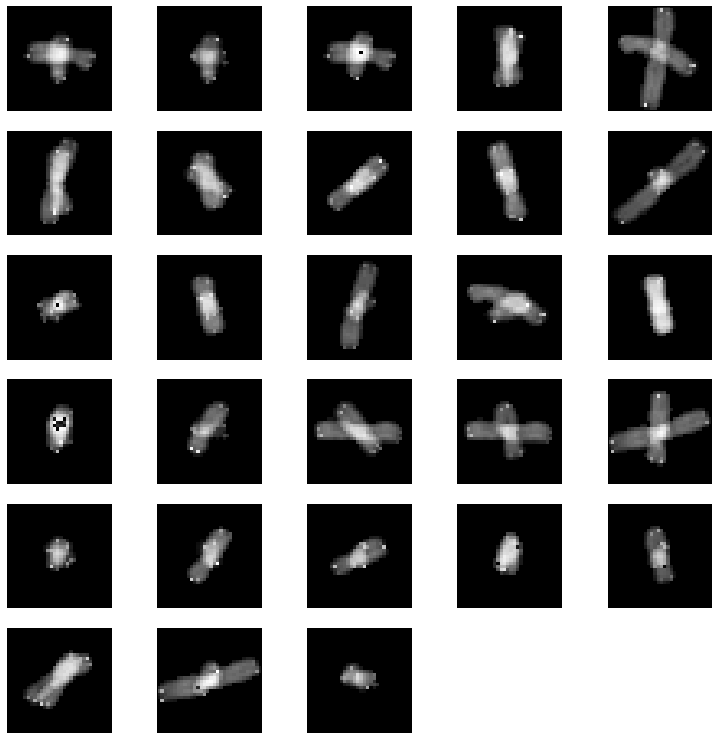

In [25]:
plt.figure(figsize=(13, 13))
for i, im in enumerate(all_pairs[::37]):
    #print im[0], im[1][0].shape, im[1][1].shape
    grey1 = im[1][0]
    grey2 = im[1][1]
    plt.subplot(6,5,i+1, xticks=[],yticks=[])
    plt.imshow(grey1 + grey2, interpolation='nearest', cmap = plt.cm.Greys_r,vmin=0, vmax=255)

In [26]:
overlapps = []
for pair in all_pairs[::37]:
    im1 = pair[1][0]
    im2 = pair[1][1]
    overl = overlapping_generator(im1,im2,rotation_step=20, translations_number=9)
    overlapps = overlapps + overl

In [27]:
print len(overlapps), ' pairs of chromosomes'

111132  pairs of chromosomes


## Resizing a large amount of images in RAM **is** the botleneck :

In [28]:
resized = ResizeImages(overlapps)

### Remove non touching chromosomes

In [29]:
overlapps = []
for ovlp in resized:
    if np.any(ovlp[:,:,1][:,:]==3):
        overlapps.append(ovlp)

Concatenate the list of images into a single array:

In [30]:
stacked = io.concatenate_images(overlapps)
print stacked.shape

(82146, 52, 52, 2)


In [31]:
m_byte = sys.getsizeof(stacked)/1024.0/1024.0/1024
print 'Stacked images '+ str(m_byte) +' Gigabytes'

Stacked images 3.30988754332 Gigabytes


## Shuffling images could be a good idea

In [32]:
print 'Shuffling images'
np.random.shuffle(stacked)
print(stacked.shape)

Shuffling images
(82146, 52, 52, 2)


## Let's have a look to the dataset:

The ground truth label is a bit noisy, see the light blue pixels touching or the lonely yellow pixels.

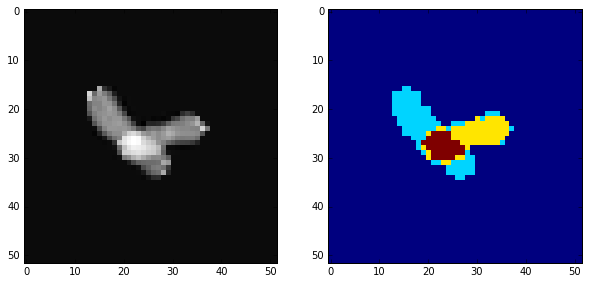

In [33]:
example = 1
grey = 0
ground_truth = 1

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(stacked[example,:,:,grey], interpolation = 'nearest', cmap = plt.cm.Greys_r)

plt.subplot(122)
plt.imshow(stacked[example,:,:,ground_truth], interpolation = 'nearest')

## Now save the dataset as a hdf5 file.

In [34]:
h5f = h5py.File('../dataset/lowres_82146_overlapping_pairs_grey_DAPI-GroundTruth.h5', 'w')
h5f.create_dataset('low res overlapping chromosomes', data= stacked, compression='gzip', compression_opts=9)
h5f.close()